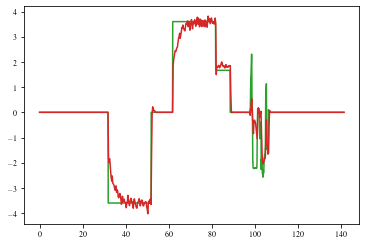

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import scipy.optimize as opti
import scipy.special as sp
import matplotlib.cm as cm
import matplotlib

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

width = 3.487
height = width / 1.618


path = './data/powertrain_analysis/pickle/left_right_from_idle_1/'
left_cmd = np.load(path+"left_cmd.pk1", allow_pickle=True)
left_meas = np.load(path+"left_meas.pk1", allow_pickle=True)
right_cmd = np.load(path+"right_cmd.pk1", allow_pickle=True)
right_meas = np.load(path+"right_meas.pk1", allow_pickle=True)

min_t = min(left_cmd['rosbagTimestamp'].tolist() + 
            left_meas['rosbagTimestamp'].tolist())

for df in (left_cmd, left_meas):
    df['rosbagTimestamp'] -= min_t
    df['rosbagTimestamp'] *= 1e-9
    
plt.plot(left_cmd['rosbagTimestamp'], left_cmd['data'], color="tab:green")
plt.plot(left_meas['rosbagTimestamp'], left_meas['data'], color="tab:red")

In [3]:
#first order system
tau=1
T = sig.lti([], [-1/tau], 1)

def step_FO_sys(t, tau=1, K=1, time_step=0):
    if not isinstance(t, np.ndarray):
        t = [t]
    t = [max(t_, time_step) for t_ in t]
    
    f = np.vectorize(lambda ti: K*(1 - np.exp(-(ti-time_step)/tau)))
    return f(t)

def step_NO_sys(t, tau=1, K=1, n=1, delay=0, time_step=0):
    if not isinstance(t, np.ndarray):
        t = [t]
    t = [max(t_, time_step+delay) for t_ in t]
    
    f = np.vectorize(lambda ti: K*(1.-sp.gammaincc(n, (ti-time_step-delay)/tau)))
    return f(t)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


1.1314148580853614 1.0


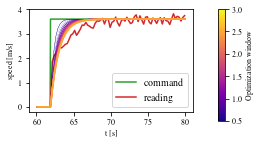

In [5]:

#extract step response
t_step = (60.,80.)
cmd = left_cmd[ (t_step[0] <= left_cmd.rosbagTimestamp) & (t_step[1] >= left_cmd.rosbagTimestamp)]
reading = left_meas[ (t_step[0] <= left_meas.rosbagTimestamp) & (t_step[1] >= left_meas.rosbagTimestamp)]

time_start = min(cmd[cmd.data > 1e-1 ]['rosbagTimestamp'])
K = max(cmd['data'])

#plotplot

plt.figure()
fig=plt.gcf()
ax = plt.gca()

ax.plot(cmd['rosbagTimestamp'], cmd['data'], color="tab:green", label="command")
ax.plot(reading['rosbagTimestamp'], reading['data'], color="tab:red", label="reading")

min_diff=.5
max_diff=3
max_ts = np.linspace(time_start+min_diff,time_start+max_diff, 20)

cmap = cm.get_cmap('plasma')
norm = matplotlib.colors.Normalize(vmin=min_diff, vmax=max_diff)

for max_t in max_ts:
    f_opti = lambda t,tau,d: step_FO_sys(t, tau, K, time_start)
    ts = reading[reading.rosbagTimestamp <= max_t]['rosbagTimestamp'].to_list()
    data = reading[reading.rosbagTimestamp <= max_t]['data']
    params = opti.curve_fit(f_opti, ts, data,
                           bounds = [(0,0),(np.inf, np.inf)])

    tau = params[0][0]
    # n = params[0][1]
    delay=params[0][1]
    
    tsp = reading['rosbagTimestamp'].to_list()
    ax.plot(tsp, [f_opti(t, tau, delay) for t in tsp], color=cmap(norm(max_t - max_ts[0])), alpha=1, lw=.1+2*norm(max_t - max_ts[0]))
print(tau, delay)
    
    
cax = fig.add_axes([0.85, 0.18, 0.03, 0.72])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label=r"Optimization window")

ax.legend()

fig.subplots_adjust(left=0.1, bottom=.24, top=.90, right=.75, wspace=.1)

ax.set_xlabel("t [s]")
ax.set_ylabel("speed [m/s]")

# ax.axvline(time_start+2)

fig.set_size_inches(width, height)
fig.savefig('figs/step1.jpg', dpi=300)

In [ ]:

#extract step response
t_step = (25.,50.)
cmd = left_cmd[ (t_step[0] <= left_cmd.rosbagTimestamp) & (t_step[1] >= left_cmd.rosbagTimestamp)]
reading = left_meas[ (t_step[0] <= left_meas.rosbagTimestamp) & (t_step[1] >= left_meas.rosbagTimestamp)]

time_start = min(cmd[cmd.data < -1e-1 ]['rosbagTimestamp'])
K = min(cmd['data'])

#plotplot

plt.figure()
fig=plt.gcf()
ax = plt.gca()

ax.plot(cmd['rosbagTimestamp'], cmd['data'], color="tab:green", label="command")
ax.plot(reading['rosbagTimestamp'], reading['data'], color="tab:red", label="reading")

min_diff=.5
max_diff=3
max_ts = np.linspace(time_start+min_diff,time_start+max_diff, 100)

cmap = cm.get_cmap('plasma')
norm = matplotlib.colors.Normalize(vmin=min_diff, vmax=max_diff)

for max_t in max_ts:
    f_opti = lambda t,tau: step_FO_sys(t, tau, K, time_start)
    ts = reading[reading.rosbagTimestamp <= max_t]['rosbagTimestamp'].to_list()
    data = reading[reading.rosbagTimestamp <= max_t]['data']
    params = opti.curve_fit(f_opti, ts, data)

    tau = params[0][0]

    tsp = reading['rosbagTimestamp'].to_list()
    ax.plot(tsp, [f_opti(t, tau) for t in tsp], color=cmap(norm(max_t - max_ts[0])), alpha=.3, lw=2)
    
cax = fig.add_axes([0.85, 0.18, 0.03, 0.72])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label=r"Optimization window")

ax.legend()

fig.subplots_adjust(left=0.1, bottom=.24, top=.90, right=.75, wspace=.1)

ax.set_xlabel("t [s]")
ax.set_ylabel("speed [m/s]")

print(tau)

# ax.axvline(time_start+2)

fig.set_size_inches(width, height)
fig.savefig('figs/step2.jpg', dpi=300)